In [ ]:
#https://github.com/etown/dl1/blob/master/UrbanSoundClassification.ipynb

import os
import glob
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import librosa.display
import numpy as np
from fastai import *
from fastai.vision import *
from fastai.vision.data import ImageDataLoaders
from fastai.vision.all import Normalize, Resize, imagenet_stats
from tqdm import tqdm

labels  = ['air_conditioner','car_horn','children_playing',
           'dog_bark','drilling','engine_idling','gun_shot','jackhammer','siren','street_music']

In [7]:
def create_fold_spectrograms(fold):
    spectrogram_path = Path('UrbanSound8K/spectrogram/')  
    audio_path = Path('UrbanSound8K/audio/')  
    if (os.path.isdir(spectrogram_path/fold)):
        print(f"Directory {spectrogram_path/fold} already exists, skipping fold {fold}")
        return
    os.mkdir(spectrogram_path/fold)

    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    for audio_file in tqdm(list(Path(audio_path/f'fold{fold}').glob('*.wav'))):
        samples, sample_rate = librosa.load(str(audio_file))
        filename = spectrogram_path/fold/Path(audio_file).name.replace('.wav','.png')
        S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
        plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close('all')

for i in range(1, 11):
    print(f'Processing fold {i} of 10')
    create_fold_spectrograms(str(i))

data_path = Path('UrbanSound8K/data/') 
spectrogram_path = Path('UrbanSound8K/spectrogram/')  
def create_fold_directory(fold):
    if (os.path.isdir(data_path/fold)):
        print(f"Directory {data_path/fold} already exists, skipping fold {fold}")
        return
    png_files =  list(Path(spectrogram_path/fold).glob('*.png'))
    os.mkdir(data_path/fold)
    os.mkdir(data_path/fold/'train')
    os.mkdir(data_path/fold/'valid')
    for label in labels:
        os.mkdir(data_path/fold/'train'/label)
        os.mkdir(data_path/fold/'valid'/label)
     
    for file in png_files:
        label = file.as_posix().split('-')[1]
        shutil.copyfile(file, data_path/fold/'valid'/labels[int(label)]/file.name)   
    for i in range(1, 11):       
        if str(i) == fold:
            continue
        png_files =  list(Path(spectrogram_path/str(i)).glob('*.png'))
        for file in png_files:
            label = file.as_posix().split('-')[1]
            shutil.copyfile(file, data_path/fold/'train'/labels[int(label)]/file.name)

for i in range(1, 11):
    create_fold_directory(str(i))


Processing fold 1 of 10
Directory UrbanSound8K\spectrogram\1 already exists, skipping fold 1
Processing fold 2 of 10
Directory UrbanSound8K\spectrogram\2 already exists, skipping fold 2
Processing fold 3 of 10
Directory UrbanSound8K\spectrogram\3 already exists, skipping fold 3
Processing fold 4 of 10
Directory UrbanSound8K\spectrogram\4 already exists, skipping fold 4
Processing fold 5 of 10
Directory UrbanSound8K\spectrogram\5 already exists, skipping fold 5
Processing fold 6 of 10
Directory UrbanSound8K\spectrogram\6 already exists, skipping fold 6
Processing fold 7 of 10
Directory UrbanSound8K\spectrogram\7 already exists, skipping fold 7
Processing fold 8 of 10
Directory UrbanSound8K\spectrogram\8 already exists, skipping fold 8
Processing fold 9 of 10
Directory UrbanSound8K\spectrogram\9 already exists, skipping fold 9
Processing fold 10 of 10
Directory UrbanSound8K\spectrogram\10 already exists, skipping fold 10
Directory UrbanSound8K\data\1 already exists, skipping fold 1
Direc

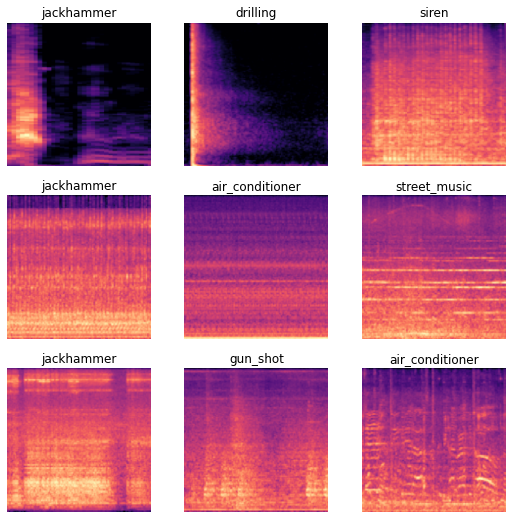

In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

data_directory = Path('UrbanSound8K/data')
# don't use any transformations because it doesn't make sense in the case of a spectrogram
# i.e. flipping a spectrogram changes the meaning
# data = ImageDataBunch.from_folder(data_directory/'1', ds_tfms=[], size=224)
# data = ImageDataLoaders.from_folder(data_directory/'1', item_tfms=[Resize(224), Normalize.from_stats(*imagenet_stats)])
data = ImageDataLoaders.from_folder(data_directory/'1', 
                                    item_tfms=Resize(224), 
                                    batch_tfms=Normalize.from_stats(*imagenet_stats))
data.show_batch(max_n=25)

def process_fold(fold):
    data_directory = Path('UrbanSound8K/data')
    # data = ImageDataBunch.from_folder(data_directory/fold, ds_tfms=[], size=224)
    data = ImageDataLoaders.from_folder(data_directory/fold, ds_tfms=[], size=224)
    data.normalize(imagenet_stats)
    learn = ConvLearner(data, models.resnet34, metrics=error_rate)
    learn.fit_one_cycle(3)
    learn.unfreeze()
    learn.fit_one_cycle(1)
    learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

In [ ]:
# process_fold('1')
# process_fold('2')
# process_fold('3')
# process_fold('4')
# process_fold('5')
# process_fold('6')
# process_fold('7')
# process_fold('8')
# process_fold('9')
# process_fold('10')